# Import library

In [88]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Loading dataset

In [89]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, np.uint8(24), datetime.datetime(2008, 4, 2, 15, 25, 41), np.float64(1.8564874208181574), np.float64(4.191491807505295), np.float64(-0.004901589207462691), np.float64(24.330033885570543), np.float64(-0.0006), np.float64(0.0), np.float64(0.0)]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,2008-05-07 01:58:43.570826240,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
min,1.000000,24.0,2008-04-02 15:25:41,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,2008-04-29 22:00:04,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,2008-05-07 21:56:09,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,2008-05-18 03:05:19,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,2008-05-27 20:45:42,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000
std,45.699687,0.0,NaN,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295


# Training the model
Calculate SoH and preparing the training dataset

Function to Calculate SoC

In [90]:
def CalculateSoC(pSoc, capacity, current, ptime, ctime):
    # Convert capacity Ah to As
    capacity = capacity * 3600  

    # Calculate the time difference
    delta_time = ctime - ptime
    
    # Calculate the integral assuming constant current
    integral_current = current * delta_time
    
    # Calculate the SoC
    SoC = pSoc + (1 / capacity) * integral_current
    # Ensure SoC is between 0 and 100
    SoC = max(0, min(SoC, 1))  
    
    return SoC

Calculate SoC for dataset

In [91]:
attrib = ['cycle', 'time', 'capacity', 'current_measured']
soc_data = dataset[attrib].copy()
SoC = [1.0]  # Initial SoC

for i in range(1, len(soc_data)):
    if soc_data['cycle'][i] != soc_data['cycle'][i - 1]:
        # Reset SoC to 1.0 at the beginning of each cycle
        SoC.append(1.0)
        continue
    # Calculate SoC using the previous cycle's data
    ptime = soc_data['time'][i - 1]
    ctime = soc_data['time'][i]
    pSoc = SoC[i - 1]
    capacity = soc_data['capacity'][i]
    current = soc_data['current_measured'][i]
    SoC.append(CalculateSoC(pSoc, capacity, current, ptime, ctime))

SoC = pd.DataFrame(data=SoC, columns=['SoC'])
print(SoC.tail(600))

            SoC
49685  0.000004
49686  0.000005
49687  1.000000
49688  0.999993
49689  0.995635
...         ...
50280  0.000002
50281  0.000000
50282  0.000000
50283  0.000003
50284  0.000001

[600 rows x 1 columns]


Create the training dataset

In [92]:
attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(SoC.shape)

(50285, 7)
(50285, 1)


Import tensorflow

In [93]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [94]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

d:\Projects-Ng\Battery_SoC_Estimation_Using_RSNN\myvenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 8)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217 (868.00 B)

 Trainable params: 217 (868.00 B)

 Non-trainable params: 0 (0.00 B)

Model is trained, 50 epochs are used for training

In [95]:
model.fit(x = train_dataset, y = SoC.to_numpy(), epochs = 50)

Epoch 1/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1685
Epoch 2/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0671
Epoch 3/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0659
Epoch 4/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0659
Epoch 5/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0649
Epoch 6/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0653
Epoch 7/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0648
Epoch 8/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0649
Epoch 9/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0657
Epoch 10/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0650
Epoch 11/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0653
Epoch 12/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0651
Epoch 13/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0653
Epoch 14/50
1572/1572 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0654
Epoch 15/50
1572/1572 ━━━━━━━

# Testing SoH prediction model
load the testing battery dataset

In [96]:
dataset_val, capacity_val = load_data('B0006')

attrib = ['cycle', 'time', 'capacity', 'current_measured']
soc_data_test = dataset_val[attrib].copy()
SoC_test = [1.0]  # Initial SoC

for i in range(1, len(soc_data)):
    if soc_data_test['cycle'][i] != soc_data_test['cycle'][i - 1]:
        # Reset SoC to 1.0 at the beginning of each cycle
        SoC_test.append(1.0)
        continue
    ptime = soc_data_test['time'][i - 1]
    ctime = soc_data_test['time'][i]
    pSoc = SoC_test[i - 1]
    capacity = soc_data_test['capacity'][i]
    current = soc_data_test['current_measured'][i]
    SoC_test.append(CalculateSoC(pSoc, capacity, current, ptime, ctime))

SoC_test_table = pd.DataFrame(data=SoC_test, columns=['SoC'])
print(SoC_test_table.tail(600))

Total data in dataset:  616
[1, np.uint8(24), datetime.datetime(2008, 4, 2, 15, 25, 41), np.float64(2.035337591005598), np.float64(4.179799607333447), np.float64(-0.0023663271409738672), np.float64(24.277567510331888), np.float64(-0.0006), np.float64(0.0), np.float64(0.0)]
            SoC
49685  0.000000
49686  0.000000
49687  1.000000
49688  0.999999
49689  0.995137
...         ...
50280  0.000000
50281  0.000000
50282  0.000000
50283  0.000000
50284  0.000000

[600 rows x 1 columns]


Create table for real SoH vs predicted SoH, calculate mean square error

In [101]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soc_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soc_pred.shape)
soc_pred_series = pd.Series(soc_pred.ravel(), name='predicted SoC')
combined_df = pd.concat([
    dataset_val['cycle'].reset_index(drop=True),
    dataset_val['time'].reset_index(drop=True),
    SoC_test_table['SoC'].reset_index(drop=True),
    soc_pred_series.reset_index(drop=True)
], axis=1)
combined_df.columns = ['cycle','time' ,'actual SoC', 'predicted SoC']
print(combined_df.head(200))



1572/1572 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
(50285, 1)
     cycle      time  actual SoC  predicted SoC
0        1     0.000    1.000000       1.007369
1        1    16.781    1.000000       0.982605
2        1    35.703    0.994798       1.019265
3        1    53.781    0.989842       1.008303
4        1    71.922    0.984858       0.999618
..     ...       ...         ...            ...
195      1  3669.875    0.000000       0.100852
196      1  3690.234    0.000000       0.100852
197      2     0.000    1.000000       1.006408
198      2    16.672    1.000000       0.981531
199      2    35.703    0.994748       1.020238

[200 rows x 4 columns]


In [102]:
rmse_global = np.sqrt(mean_squared_error(combined_df['actual SoC'], combined_df['predicted SoC']))
print(f"Global RMSE: {rmse_global:.5f}")

Global RMSE: 0.06151


Plot SoH

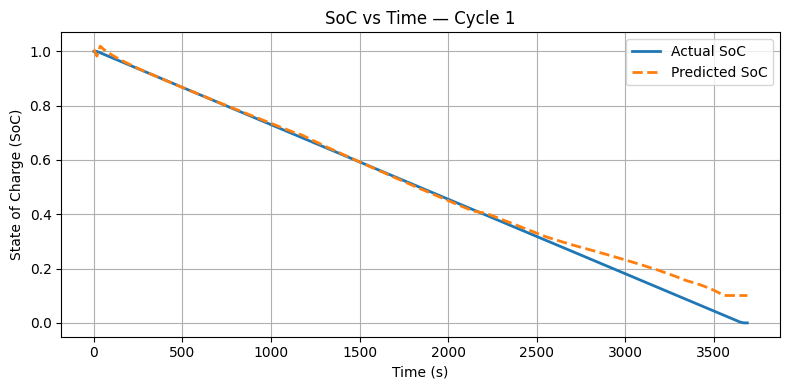

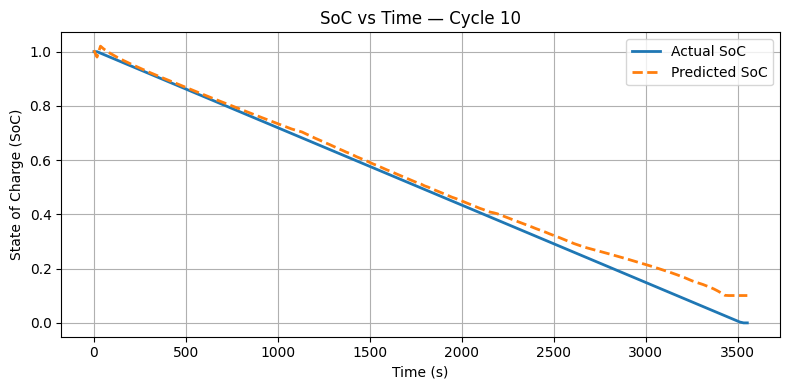

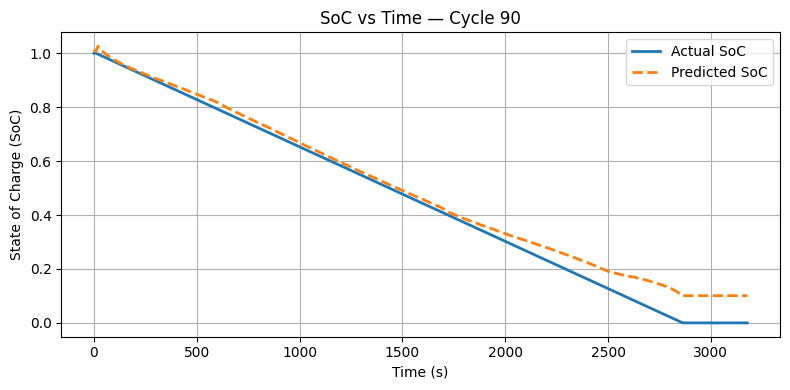

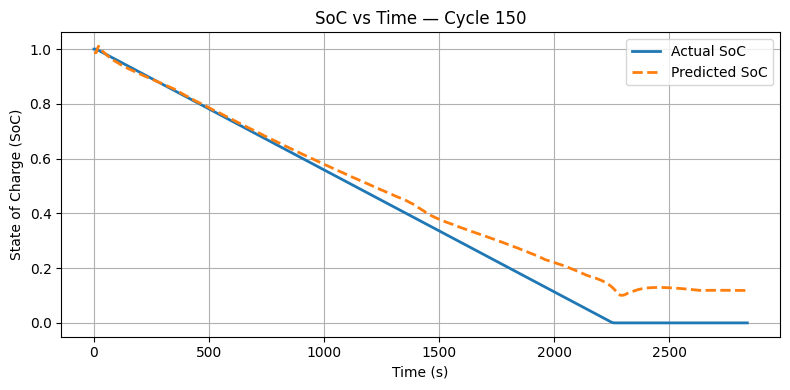

In [104]:
for cycle_id in [1, 10, 90, 150]:
    cycle_data = combined_df[combined_df['cycle'] == cycle_id]
    
    plt.figure(figsize=(8, 4))
    plt.plot(cycle_data['time'], cycle_data['actual SoC'], label='Actual SoC', linewidth=2)
    plt.plot(cycle_data['time'], cycle_data['predicted SoC'], label='Predicted SoC', linestyle='--', linewidth=2)
    
    plt.title(f"SoC vs Time — Cycle {cycle_id}")
    plt.xlabel("Time (s)")  # Adjust unit if different
    plt.ylabel("State of Charge (SoC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
